# Data Management and Data Analytics Capstone 
## NLP-based AI for Legal Assistance
### This project will determine relevant prior cases (precendents) for a given situation 
>  The importance of prior cases is greatly emphasized in a Common Law System. Prior cases, also known as precedents, are court cases from the past that discuss similar issues and can serve as references in the current case. Prior cases are considered as important as any other law to ensure that a similar situation is treated similarly in every case. It is expected that a court will follow the interpretations made in a prior case in current cases where relevant legal issues have already been decided. Therefore, lawyers must research prior cases and see how courts have interpreted the contemporary legal issue.
Recent developments in technology have led to a rapid increase in digital legal documents. Therefore, an automatic precedent retrieval system is imperative for legal professionals. An approach to precedent retrieval could be represented as a task of information retrieval, where the system would retrieve relevant prior cases based on the current case document. Furthermore, legal texts tend to be complex and lengthy. 
As a result of the requirements described above, the project focuses on retrieving precedence using Natural Language Processing (NLP).

## Intial Setup
> Python Version used

In [1]:
!python --version

Python 3.8.8


### List of Libraries to install.
> Kernal needs to be restarted after installing

In [2]:
#!pip install umap-learn
#!pip install sklearn
#!pip install rank-bm25
#!pip install nltk

 It takes a minimum of 30 minutes to run the notebook entirely. The reason for such a long time processing is:
 - The dimension reduction library has to reduce 65549 dimensions to 2 dimensions.
 - The cosine similarity score for group 2 has 1333 cases to calculate

## Importing all the libraries required for the analysis

In [3]:
# Importing all the libraries required

import os
import math
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import glob # returns all file paths that match specific pattern
import re # regular expression
import random
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN,KMeans
from scipy.spatial import distance

# Dimension Reduction Libraries
import umap


## Data Collection

Three datasets have been given:
- The first dataset has 2914 court decisions that were judged in the Supreme Court of India.
- The second is an experimental dataset necessary to search relevant prior cases.
- The third is a query dataset.

The above datasets are in .txt format and needs to be enclosed in a csv file for ease of use

The following steps were taken to enclose all the text files in a single CSV file:

- In order to read all the text files from the object_casedocs folder, I created a list and added all the text files to it.
- .txt has been replaced with a space.
- Created a dataframe.
- In the next step, I saved the dataframe into a CSV file called casedoc.csv.
- Reading the CSV file

In [4]:
# Enclosing first dataset i.e., 2914 case documents judged in the Supreme Court of India, into a csv file.
# Creating a list called case_list and appending all the text files into it

import os
from os.path import abspath
case_list = []
relative_file_path = ".\Object_casedocs"

# replacing single backslash with doube backslash for windows

file_path = os.path.abspath(relative_file_path).replace("\\","\\")

for filename in os.listdir(file_path):
    #print (filename)
    with open(os.path.join(file_path, filename), 'r') as f: # open in readonly mode
        text = f.read()
        #print (text)
    case_list.append([filename.replace('.txt', ''),text])
    #print(case_list)

In [5]:
# Adding the case_list into dataframe

df = pd.DataFrame (case_list, columns = ['case_num', 'case_detail'])
print (df)

     case_num                                        case_detail
0          C1  Masud Khan v State Of Uttar Pradesh\nSupreme C...
1         C10  Prabhakaran Nair, Etc. v State Of Tamil Nadu A...
2        C100  Hiten P. Dalal v Bratindranath Banerjee\nSupre...
3       C1000  Ashok Kumar and Others v State of Tamil Nadu\n...
4       C1001  Ashok Dhingra v N.C.T. of Delhi\nSupreme Court...
...       ...                                                ...
2909     C995  Rajendra Singh v State of Uttaranchal\nSupreme...
2910     C996  Food Corporation Of India & Anr v Seil Ltd. & ...
2911     C997  State of Kerala v Sasi\nSupreme Court of India...
2912     C998  Columbia Sportswear Company v Director Of Inco...
2913     C999  Bharat Gurjar and others v State of Rajasthan\...

[2914 rows x 2 columns]


In [6]:
# Saving the dataframe to csv file called casedoc.csv

df.to_csv("casedoc.csv", index=False)

In [7]:
# Reading the csv file casedoc.csv.

case_df = pd.read_csv('casedoc.csv')
case_df

,case_num,case_detail
0,C1,Masud Khan v State Of Uttar Pradesh\nSupreme C...
1,C10,"Prabhakaran Nair, Etc. v State Of Tamil Nadu A..."
2,C100,Hiten P. Dalal v Bratindranath Banerjee\nSupre...
3,C1000,Ashok Kumar and Others v State of Tamil Nadu\n...
4,C1001,Ashok Dhingra v N.C.T. of Delhi\nSupreme Court...
...,...,...
2909,C995,Rajendra Singh v State of Uttaranchal\nSupreme...
2910,C996,Food Corporation Of India & Anr v Seil Ltd. & ...
2911,C997,State of Kerala v Sasi\nSupreme Court of India...
2912,C998,Columbia Sportswear Company v Director Of Inco...


### Loading the second dataset - relevance_judgments_priorcases.txt 

In [8]:
# All training query data as well as the relevant document data provided to us is stored
# It is used to check whether the model gives accurate relevant cases or not at the end. This is checked by using precision and recall

relevant_cases = pd.read_csv("relevance_judgments_priorcases.txt", delimiter = " ", header = None)
relevant_cases.columns = ["Query_num", "Q0", "Doc_num" ,"Relevance_score"]
relevant_cases = relevant_cases.drop(columns=["Q0"]) # since column is not required for any purpose, the column will be dropped
relevant_cases

,Query_num,Doc_num,Relevance_score
0,AILA_Q1,C168,0
1,AILA_Q1,C382,0
2,AILA_Q1,C428,0
3,AILA_Q1,C949,0
4,AILA_Q1,C2303,0
...,...,...,...
145695,AILA_Q50,C1367,0
145696,AILA_Q50,C2079,0
145697,AILA_Q50,C2066,0
145698,AILA_Q50,C1951,0


#### A Relevance_score of "1" indicates correct prior cases and a Relevance_score of "0" indicates wrong prior cases

In [9]:
# Checking to see the Relevance_score of "1"

relevant_cases[relevant_cases.Relevance_score ==1]

,Query_num,Doc_num,Relevance_score
1192,AILA_Q1,C14,1
2274,AILA_Q1,C9,1
3076,AILA_Q2,C27,1
3676,AILA_Q2,C22,1
6033,AILA_Q3,C1,1
...,...,...,...
140861,AILA_Q49,C38,1
142203,AILA_Q49,C76,1
142450,AILA_Q49,C92,1
143069,AILA_Q50,C27,1


In [10]:
# Checking to see the Relevance_score of "0"

relevant_cases[relevant_cases.Relevance_score ==0]

,Query_num,Doc_num,Relevance_score
0,AILA_Q1,C168,0
1,AILA_Q1,C382,0
2,AILA_Q1,C428,0
3,AILA_Q1,C949,0
4,AILA_Q1,C2303,0
...,...,...,...
145695,AILA_Q50,C1367,0
145696,AILA_Q50,C2079,0
145697,AILA_Q50,C2066,0
145698,AILA_Q50,C1951,0


## Text Preprocessing - Data cleaning
- Lowercase, punctuation, and special characters are removed
- Removing stopwords
- Stemming
- Lemmatization
> Stemming and Lemmatization in Python NLTK are text normalization techniques for Natural Language Processing. These techniques are widely used for text preprocessing. The difference between stemming and lemmatization is that stemming is faster as it cuts words without knowing the context, while lemmatization is slower as it knows the context of words before processing.

The challenges faced while text preprocessing:
- Dates were in different format like '09012002', '10.8.2013', etc., and had to be removed
- Mixing of letter with numbers and special characters that doenst make sense like '100that', '_they' 
- No space between words like 'Administrationpersonnelrevenu', 'Accusedhusband'

In [11]:
# Text Preprocessing using NLTK library

lst_stopwords = nltk.corpus.stopwords.words("english")
def text_preprocess(each_case_detail):
    
    #replace hyphens and other special characters with space
    #remove date with different formats
    each_case_detail = each_case_detail.replace('-',' ').replace(',',' ').replace("'",' ').replace('/',' ').replace('\\',' ').replace('(',' ').replace(')',' ')
    each_case_detail = re.sub(r'[0-9]{2}\s+[0-9]{2}\s+[0-9]{4}', '',each_case_detail)
    each_case_detail = re.sub(r'[0-9]{2}\s+[0-9]{1}\s+[0-9]{4}', '',each_case_detail)
    each_case_detail = re.sub(r'[0-9]{1}\s+[0-9]{2}\s+[0-9]{4}', '',each_case_detail)   
    each_case_detail = re.sub(r'[0-9]{1}\s+[0-9]{1}\s+[0-9]{4}', '',each_case_detail)
    each_case_detail = re.sub(r'[0-9]{2}\.+[0-9]{2}\.+[0-9]{4}', '',each_case_detail)
    
    each_case_detail = re.sub(r'[^\w\s]', '', str(each_case_detail).lower().strip())
    
    #tokenization
    each_case_detail_list = each_case_detail.split()
    
    #remove stopwords
    each_case_detail_list = [word for word in each_case_detail_list if word not in lst_stopwords]
        
    #stemming
    port_stem = nltk.stem.porter.PorterStemmer()
    each_case_detail_list = [port_stem.stem(word) for word in each_case_detail_list]
        
    #Lemmentization
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    each_case_detail_list = [lem.lemmatize(word) for word in each_case_detail_list]
        
    # back to string from list
    each_case_detail = " ".join(each_case_detail_list)
    return each_case_detail

In [12]:
# Creating a column called clean_case_detail to store preprocessed case_detail text

case_df['clean_case_detail'] = case_df['case_detail'].apply(lambda x: text_preprocess(x))
case_df['clean_case_detail']

0       masud khan v state uttar pradesh suprem court ...
1       prabhakaran nair etc v state tamil nadu or sup...
2       hiten p dalal v bratindranath banerje suprem c...
3       ashok kumar other v state tamil nadu suprem co...
4       ashok dhingra v nct delhi suprem court india 3...
                              ...                        
2909    rajendra singh v state uttaranch suprem court ...
2910    food corpor india anr v seil ltd or suprem cou...
2911    state kerala v sasi suprem court india 31 octo...
2912    columbia sportswear compani v director incom t...
2913    bharat gurjar other v state rajasthan suprem c...
Name: clean_case_detail, Length: 2914, dtype: object

In [13]:
# Saving the cleaned case_df into a csv file called casedoc_cleaned1

case_df.to_csv("clean_casedoc_1.csv", index=False)

In [14]:
# Reading the csv file casedoc_cleaned1 and assigning it to casedoc_cleaned

casedoc_cleaned = pd.read_csv("clean_casedoc_1.csv")


## Converting a collection of raw documents to a matrix of TF-IDF features
> When dealing with textual data, it first needs to be converted to a vector of numerical data by vectorization, which was achieved using the TF-IDF vectorizer. Once the vectors are created, it is applied to the dataset to see if the two documents are similar by comparing their TF-IDF vector using Cosine Similarity. The efficiency of the TF-IDF function is determined using Precision and Recall metrics.

In [15]:
thisvectorizer = TfidfVectorizer()
X = thisvectorizer.fit_transform(casedoc_cleaned.clean_case_detail)
tfidf_matrix = X.toarray()
features = thisvectorizer.get_feature_names_out()

In [16]:
thisvectorizer.get_feature_names_out()

array(['00', '000', '00000', ..., 'zygomat', 'zygot', 'zzz'], dtype=object)

In [17]:
all_tokens = thisvectorizer.get_feature_names_out().tolist()

#### Saving the tokens for analysis

In [18]:
with open('all_tokens1.txt', 'w') as fp:
    for each_token in all_tokens:
        # write each item on a new line
        fp.write("%s\t" % each_token)
    print('Done')

Done


In [19]:
len(thisvectorizer.get_feature_names_out())

65549

As we can see that we have got a dimension of 65549 and we need to reduce it by using Dimension Reduction methods

In [20]:
# Saving the tfidf_matrix so that we don't have to run the program from beggining if in case we have to restart the kernel in between

type(tfidf_matrix)

numpy.ndarray

In [21]:
np.save('tfidf_matrix', tfidf_matrix)

In [22]:
tfidf_matrix =np.load('tfidf_matrix.npy')

## Dimension Reduction using UMAP library

In [23]:
reducer = umap.UMAP()

In [24]:
reducer = umap.UMAP(n_components=2, n_neighbors=5, random_state=42, transform_seed=42, verbose=False)

In [25]:
reducer.fit(tfidf_matrix)

UMAP(n_neighbors=5, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [26]:
case_text_umap = reducer.transform(tfidf_matrix)

Below we can see that the UMAp library has done a good job in reducing 65549 dimensions to just 2 dimesions. It took some time to reduce though

In [27]:
case_text_umap.shape # To check Dimension reduction

(2914, 2)

As it took some time to reduce the dimension, lets save this reduced dimension

In [28]:
type(case_text_umap)

numpy.ndarray

In [29]:
np.save('case_text_umap', case_text_umap) # Saving

In [30]:
case_text_umap =np.load('case_text_umap.npy') # Loading

Now lets see how it looks when we plot and take a look at the cases to see if there are any similarities

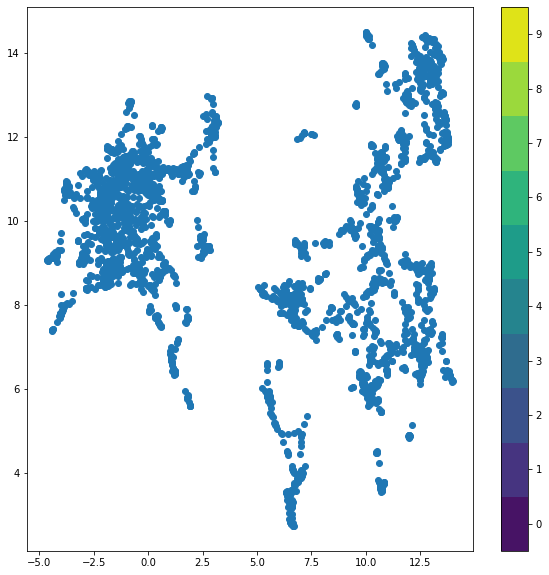

In [31]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()
plt.scatter(
    case_text_umap[:, 0],
    case_text_umap[:, 1],
)
plt.colorbar(boundaries=np.arange(11) - 0.5).set_ticks(np.arange(10))

#### Although we couldn't deduce anything from the above plot, we can see that three groups have formed

In [32]:
case_text_umap

array([[ 7.03886  ,  4.8537006],
       [11.983278 ,  7.688015 ],
       [ 7.8823686,  8.625468 ],
       ...,
       [-1.9239386, 10.2039995],
       [10.83948  ,  8.605299 ],
       [-1.0862074, 10.562955 ]], dtype=float32)

### Based on the above plot, it can be seen that there are three distinct groups, so let's cluster the cases together and examine any similarities between them when plotted using K-means clustering.

## K-means clustering methodology
> In the K-means clustering methodology, similar items are grouped into clusters. K represents the number of groups. The elbow method is used to choose the correct value of K and improve model performance

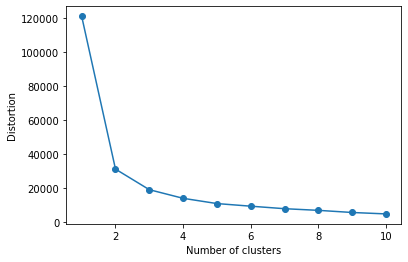

In [33]:
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(case_text_umap)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

As we can see in the resulting plot, the elbow is located at k = 3, which is evidence that k = 3 is indeed a good choice for this dataset.

In [34]:
km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
group_km = km.fit_predict(case_text_umap)

Now lets label our point with cluster information

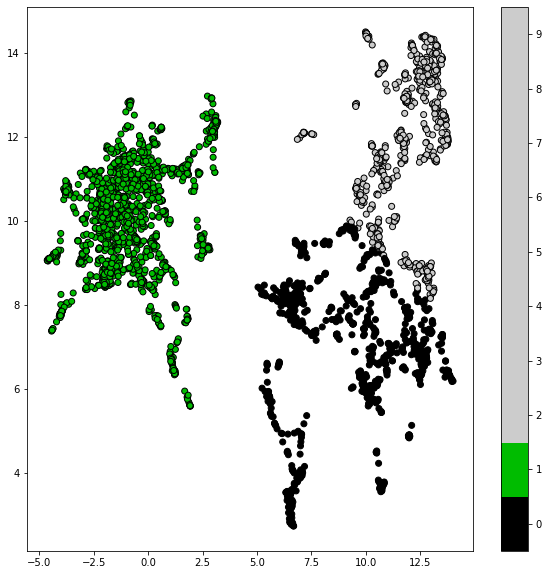

In [35]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()
plt.scatter(
    case_text_umap[:, 0],
    case_text_umap[:, 1],
    c=group_km,
    cmap=plt.cm.nipy_spectral,
    edgecolor="k",
    label=group_km,
)
plt.colorbar(boundaries=np.arange(11) - 0.5).set_ticks(np.arange(10))
plt.savefig("case_text_2D_umap.svg")

- As we can see in the above plot, there is some similarity between three groups of datasets. 
- Let's try another clustering methodology called DBSCAN to see if we can make more sense of the above plot.

## DBSCAN clustering methodology
> The DBScan method is used to group similar data points. DBScan is an unsupervised learning method

In [36]:
dbscan = DBSCAN(eps=0.7, min_samples=6)
group_dbscan = dbscan.fit_predict(case_text_umap)
dbscan.labels_

array([0, 1, 1, ..., 2, 1, 2], dtype=int64)

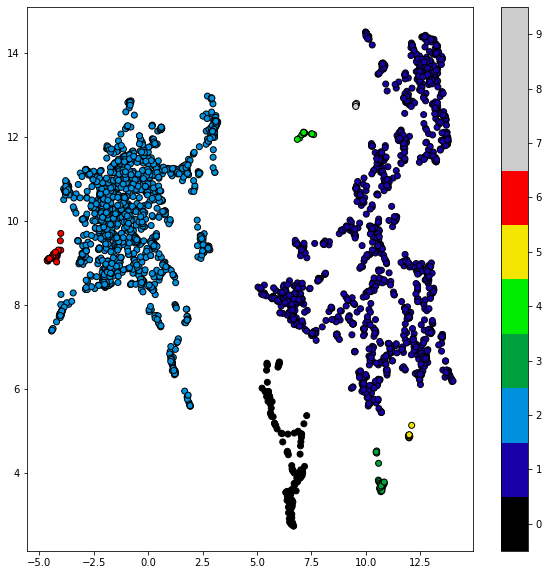

In [37]:
fig = plt.figure(1, figsize=(10, 10))
plt.clf()
plt.scatter(
    case_text_umap[:, 0],
    case_text_umap[:, 1],
    c=group_dbscan,
    cmap=plt.cm.nipy_spectral,
    edgecolor="k",
    label=group_dbscan,
)
plt.colorbar(boundaries=np.arange(11) - 0.5).set_ticks(np.arange(10))
plt.savefig("case_text_2D_umap.svg")

#### A comparison of the above plot shows how similar the cases are

Saving the clusters back to original cleaned case_doc dataframe

In [38]:
casedoc_cleaned['group_kmeans'] = group_km
casedoc_cleaned['group_dbscan'] = group_dbscan
casedoc_cleaned

,case_num,case_detail,clean_case_detail,group_kmeans,group_dbscan
0,C1,Masud Khan v State Of Uttar Pradesh\nSupreme C...,masud khan v state uttar pradesh suprem court ...,0,0
1,C10,"Prabhakaran Nair, Etc. v State Of Tamil Nadu A...",prabhakaran nair etc v state tamil nadu or sup...,0,1
2,C100,Hiten P. Dalal v Bratindranath Banerjee\nSupre...,hiten p dalal v bratindranath banerje suprem c...,0,1
3,C1000,Ashok Kumar and Others v State of Tamil Nadu\n...,ashok kumar other v state tamil nadu suprem co...,1,2
4,C1001,Ashok Dhingra v N.C.T. of Delhi\nSupreme Court...,ashok dhingra v nct delhi suprem court india 3...,0,0
...,...,...,...,...,...
2909,C995,Rajendra Singh v State of Uttaranchal\nSupreme...,rajendra singh v state uttaranch suprem court ...,1,2
2910,C996,Food Corporation Of India & Anr v Seil Ltd. & ...,food corpor india anr v seil ltd or suprem cou...,0,1
2911,C997,State of Kerala v Sasi\nSupreme Court of India...,state kerala v sasi suprem court india 31 octo...,1,2
2912,C998,Columbia Sportswear Company v Director Of Inco...,columbia sportswear compani v director incom t...,0,1


### We will use the Cosine Similarity method to determine whether the cases are similar

## Cosine Similarity

In [39]:
def cosine_similarity(vector1, vector2):
    cosine_similarity = 1 - distance.cosine(vector1, vector2)
    return(cosine_similarity)

### Let's see Cosine Similarity score for DBSCAN group "6".

In [40]:
casedoc_cleaned[casedoc_cleaned.group_dbscan==6]

,case_num,case_detail,clean_case_detail,group_kmeans,group_dbscan
47,C1040,Santhanam v State of Tamil Nadu\nSupreme Court...,santhanam v state tamil nadu suprem court indi...,1,6
136,C1120,Budhi Lal v State Of Uttarakhand\nSupreme Cour...,budhi lal v state uttarakhand suprem court ind...,1,6
299,C1268,Kailash v State Of M.P.\nSupreme Court of Indi...,kailash v state mp suprem court india 29 septe...,1,6
378,C1339,Shanmugam @ Kulandaivalu v State of Tamil Nadu...,shanmugam kulandaivalu v state tamil nadu supr...,1,6
520,C1467,Ambaram v State Of M.P\nSupreme Court of India...,ambaram v state mp suprem court india 27 april...,1,6
602,C1540,Khuman Singh and Others v State of Madhya Prad...,khuman singh other v state madhya pradesh supr...,1,6
638,C1573,Chamru Budwa v State of Madhya Pradesh\nSuprem...,chamru budwa v state madhya pradesh suprem cou...,1,6
672,C1603,Uttam Prasad and Others v State of Uttar Prade...,uttam prasad other v state uttar pradesh supre...,1,6
734,C166,Narayanan Nair Raghavan Nair v State of Travan...,narayanan nair raghavan nair v state travancor...,1,6
790,C171,Kikar Singh v State of Rajasthan\nSupreme Cour...,kikar singh v state rajasthan suprem court ind...,1,6


In [41]:
group_6 = casedoc_cleaned[casedoc_cleaned.group_dbscan==6]
group_6["index"] = group_6.index
group_6_list = group_6.index.to_list()
len_group_6_list =len(group_6_list)
len_group_6_list

<ipython-input-41-9b155774c9ae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_6["index"] = group_6.index


42

In [42]:
i=0 

#min_cos_simil =float('+inf')
max_cos_simil =0
lst_all_group6 =[]
while  i < len_group_6_list:
    j= i+1
    
    while j < len_group_6_list:
        
        # extract Vectors
        first_vec = tfidf_matrix[group_6_list[i]]
        sec_vec   = tfidf_matrix[group_6_list[j]]
        
        #find each pair wise similarity
        simi_this_iter = cosine_similarity(first_vec, sec_vec)
        
        # add vectors and each pair wise similarity to a  list
        lst_all_group6.append([group_6_list[i],group_6_list[j],simi_this_iter])
        j+=1
    i+=1

#inplace sorting  in reverse manner
lst_all_group6.sort(key=lambda x: x[2],reverse=True)
lst_all_group6

[[47, 2413, 0.9183694473819908],
 [2413, 2841, 0.904517632429466],
 [2004, 2413, 0.9030056534947198],
 [47, 2841, 0.8889069822614823],
 [47, 2004, 0.8885671275511171],
 [2004, 2841, 0.8731104846800735],
 [2413, 2668, 0.8497012738243935],
 [1319, 2413, 0.8317664120658039],
 [47, 2668, 0.831225039090837],
 [2004, 2668, 0.8198199697545401],
 [1319, 2004, 0.8165108770885187],
 [47, 1319, 0.8159796940728563],
 [136, 2413, 0.8158677165929353],
 [2668, 2841, 0.8149816734476932],
 [1319, 2841, 0.8096257809127257],
 [1926, 2413, 0.8054865245683346],
 [136, 2841, 0.8019372482800667],
 [47, 136, 0.8010979726590337],
 [2318, 2413, 0.7991958703081272],
 [47, 2318, 0.7988513487224238],
 [47, 1926, 0.7927872295852805],
 [136, 2004, 0.7917003827185763],
 [1926, 2004, 0.7855386469951887],
 [2004, 2318, 0.7828066432579646],
 [1926, 2841, 0.7789566913716003],
 [2318, 2841, 0.7779635558162177],
 [47, 2870, 0.7719971890869224],
 [2413, 2870, 0.7704878894925268],
 [1761, 2413, 0.7678855764046912],
 [1764, 2

For group "6" we have a similarity score of 91%, which is excellent

### Let's see Cosine Similarity score for DBSCAN group "7"

In [43]:
casedoc_cleaned[casedoc_cleaned.group_dbscan==7]

,case_num,case_detail,clean_case_detail,group_kmeans,group_dbscan
459,C1411,Bhawani Prasad Sonkar v Union Of India & Ors.\...,bhawani prasad sonkar v union india or suprem ...,2,7
793,C1712,I.G. (Karmik) And Others v Prahalad Mani Tripa...,ig karmik other v prahalad mani tripathi supre...,2,7
1026,C1922,V. Sivamurthy v State Of Andhra Pradesh & Ors....,v sivamurthi v state andhra pradesh or suprem ...,2,7
1069,C1961,Union Bank of India and Others v M.T. Latheesh...,union bank india other v mt latheesh suprem co...,2,7
1486,C2336,Director General of Posts and others v K. Chan...,director gener post other v k chandrashekar ra...,2,7
1978,C278,State of Haryana and Another v Ankur Gupta\nSu...,state haryana anoth v ankur gupta suprem court...,2,7
2728,C831,Rajasthan State Road Transport Corporation and...,rajasthan state road transport corpor other v ...,2,7
2762,C862,State Of Jharkhand & Ors v Shiv Karampal Sahu\...,state jharkhand or v shiv karamp sahu suprem c...,2,7
2883,C971,Messrs Indian Drugs and Pharmaceuticals Limite...,messr indian drug pharmaceut limit v devki dev...,2,7
2908,C994,"General Manager, State Bank of India and Other...",gener manag state bank india other v anju jain...,2,7


In [44]:
group_7 = casedoc_cleaned[casedoc_cleaned.group_dbscan==7]
group_7["index"] = group_7.index
group_7_list = group_7.index.to_list()
len_group_7_list =len(group_7_list)
len_group_7_list

<ipython-input-44-70fcf9c98650>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_7["index"] = group_7.index


10

In [45]:
i=0 

#min_cos_simil =float('+inf')
max_cos_simil =0
lst_all_group7 =[]
while  i < len_group_7_list:
    j= i+1
    
    while j < len_group_7_list:
        
        # extract Vectors
        first_vec = tfidf_matrix[group_7_list[i]]
        sec_vec   = tfidf_matrix[group_7_list[j]]
        
        #find each pair wise similarity
        simi_this_iter = cosine_similarity(first_vec, sec_vec)
        
        # add vectors and each pair wise similarity to a  list
        lst_all_group7.append([group_7_list[i],group_7_list[j],simi_this_iter])
        j+=1
    i+=1

#inplace sorting  in reverse manner
lst_all_group7.sort(key=lambda x: x[2],reverse=True)
lst_all_group7

[[1069, 2908, 0.7604669486754606],
 [1026, 1978, 0.7023440863220314],
 [793, 1978, 0.682207275862051],
 [459, 1026, 0.6721885354505024],
 [1069, 1978, 0.6541428187205129],
 [1026, 1069, 0.6532352895676964],
 [793, 1026, 0.6517223372910269],
 [1026, 2908, 0.6310613857685857],
 [1026, 1486, 0.6191244530751098],
 [1978, 2908, 0.6170768444979288],
 [459, 1069, 0.6150765155475819],
 [1978, 2883, 0.6038363773388908],
 [1486, 1978, 0.5990245232492583],
 [459, 1978, 0.587694500803307],
 [459, 2908, 0.5806734402009444],
 [793, 1069, 0.5765694335126313],
 [1069, 1486, 0.5712372773038635],
 [793, 2908, 0.5528438149756814],
 [1069, 2883, 0.5455689337507251],
 [459, 793, 0.5416029603329676],
 [793, 2883, 0.5407466557662359],
 [1026, 2883, 0.5363740792033993],
 [1486, 2908, 0.5271474842809952],
 [459, 1486, 0.5242437322237957],
 [793, 2728, 0.5167458950712533],
 [793, 1486, 0.5128247742955856],
 [2883, 2908, 0.4991147696735958],
 [459, 2883, 0.49257924705205436],
 [1978, 2728, 0.4811107387986022],
 

For group "7" we have a similarity score of 76%, which is pretty good

### Let's see Cosine Similarity score for DBSCAN group "2"

In [46]:
casedoc_cleaned[casedoc_cleaned.group_dbscan==2]

,case_num,case_detail,clean_case_detail,group_kmeans,group_dbscan
3,C1000,Ashok Kumar and Others v State of Tamil Nadu\n...,ashok kumar other v state tamil nadu suprem co...,1,2
6,C1003,Main Pal v State of Haryana\nSupreme Court of ...,main pal v state haryana suprem court india 7 ...,1,2
14,C1010,State of Rajasthan v Parmendra Singh\nSupreme ...,state rajasthan v parmendra singh suprem court...,1,2
15,C1011,Sohrabkhan v State of Madhya Pradesh\nSupreme ...,sohrabkhan v state madhya pradesh suprem court...,1,2
19,C1015,Janak Singh And Anr. v State Of Uttar Pradesh\...,janak singh anr v state uttar pradesh suprem c...,1,2
...,...,...,...,...,...
2906,C992,Brij Lal v State Of Haryana\nSupreme Court of ...,brij lal v state haryana suprem court india 4 ...,1,2
2907,C993,V. K. Kannan v State By the Inspector of Polic...,v k kannan v state inspector polic suprem cour...,1,2
2909,C995,Rajendra Singh v State of Uttaranchal\nSupreme...,rajendra singh v state uttaranch suprem court ...,1,2
2911,C997,State of Kerala v Sasi\nSupreme Court of India...,state kerala v sasi suprem court india 31 octo...,1,2


In [47]:
group_2 = casedoc_cleaned[casedoc_cleaned.group_dbscan==2]
group_2["index"] = group_2.index
group_2_list = group_2.index.to_list()
len_group_2_list =len(group_2_list)
len_group_2_list

<ipython-input-47-9027537cb292>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_2["index"] = group_2.index


1333

In [48]:
i=0 

#min_cos_simil =float('+inf')
max_cos_simil =0
lst_all_group2 =[]
while  i < len_group_2_list:
    j= i+1
    
    while j < len_group_2_list:
        
        # extract Vectors
        first_vec = tfidf_matrix[group_2_list[i]]
        sec_vec   = tfidf_matrix[group_2_list[j]]
        
        #find each pair wise similarity
        simi_this_iter = cosine_similarity(first_vec, sec_vec)
        
        # add vectors and each pair wise similarity to a  list
        lst_all_group2.append([group_2_list[i],group_2_list[j],simi_this_iter])
        j+=1
    i+=1

#inplace sorting  in reverse manner
lst_all_group2.sort(key=lambda x: x[2],reverse=True)
#lst_all_group2

In [49]:
lst_all_group2[0:5]

[[1608, 2664, 0.9993109464540872],
 [1561, 1609, 0.9993000150696634],
 [1671, 1848, 0.9983142198785983],
 [1925, 2385, 0.9982966017589223],
 [1243, 2332, 0.993407338179089]]

For group "2" we have a similarity score of 99%, which is excellent

### Similarity score for different group cluster cases (between group 6 and 2)

In [50]:
i = 0 

dis_sim_lst =[]
while  i < len_group_6_list:
    j = 0       
    
    while j < len_group_2_list:
        
        # extract Vectors
        first_vec = tfidf_matrix[group_6_list[i]]
        sec_vec   = tfidf_matrix[group_2_list[j]]
        
        #find each pair wise similarity
        simi_this_iter = cosine_similarity(first_vec, sec_vec)
        
        # add vectors and each pair wise similarity to a  list
        dis_sim_lst.append([group_6_list[i],group_2_list[j],simi_this_iter])
        j+=1
    i+=1

#inplace sorting  in reverse manner
dis_sim_lst.sort(key=lambda x: x[2])
dis_sim_lst

[[1570, 148, 0.01920799252707983],
 [2848, 1127, 0.019425301922971094],
 [2128, 148, 0.02033600439196137],
 [2892, 1127, 0.022424421188936283],
 [1783, 148, 0.023768490705981637],
 [2848, 625, 0.02451293999042259],
 [2892, 1752, 0.02504539777254322],
 [520, 1127, 0.025053117722657836],
 [2848, 1752, 0.025439602679301343],
 [734, 1869, 0.02558020540517003],
 [2322, 148, 0.025759426059640878],
 [1351, 148, 0.026093295510521752],
 [1649, 148, 0.026117400175050598],
 [934, 148, 0.026212305666195146],
 [2848, 2146, 0.026241015235955234],
 [638, 453, 0.02634542479224844],
 [2128, 2444, 0.026488144643405098],
 [1649, 1127, 0.026658101107353338],
 [734, 472, 0.026734046349305318],
 [2848, 1640, 0.02686413440758484],
 [2892, 625, 0.026927226075777466],
 [1783, 2378, 0.02698209281842545],
 [734, 1444, 0.02733365363593543],
 [1570, 1283, 0.027702157046351705],
 [2476, 2310, 0.027798607358597627],
 [520, 1283, 0.027873074222619976],
 [1351, 2444, 0.028019063826287827],
 [1649, 2827, 0.028075011320

Similarity scores between two different groups range from 1% to 2%, which is expected

## Using the Query_data provided, let's create a test dataframe

In [51]:
query_cases = pd.read_csv("Query_doc.txt", delimiter = "|", header = None)
query_cases.columns = ["Query_num", "None", "Query"]
query_cases = query_cases.drop(columns=["None"]) 
query_cases

,Query_num,Query
0,AILA_Q1,"The appellant on February 9, 1961 was appointe..."
1,AILA_Q2,The appellant before us was examined as prime ...
2,AILA_Q3,This appeal arises from the judgment of the le...
3,AILA_Q4,The Petitioner was married to the Respondent N...
4,AILA_Q5,This appeal is preferred against the judgment ...
5,AILA_Q6,"On 19.3.1999, SI P1 along Ct. P2 went to Villa..."
6,AILA_Q7,This criminal appeal is directed against the j...
7,AILA_Q8,"This appeal, by special leave, has been prefer..."
8,AILA_Q9,The complainant P1 filed a Special Leave Petit...
9,AILA_Q10,"The four appellants, along with P1 son of P2, ..."


### Following similar steps to preprocess object_casedocs data, we need to preprocess Query_data as well

## Preprocessing Query_data

In [52]:
lst_stopwords = nltk.corpus.stopwords.words("english")
def query_preprocess(query_case_detail):
    
    #replace hyphens and other special characters with space
    #remove date with different formats
    query_case_detail = query_case_detail.replace('-',' ').replace(',',' ').replace("'",' ').replace('/',' ').replace('\\',' ').replace('(',' ').replace(')',' ')
    query_case_detail = re.sub(r'[0-9]{2}\s+[0-9]{2}\s+[0-9]{4}', '',query_case_detail)
    query_case_detail = re.sub(r'[0-9]{2}\s+[0-9]{1}\s+[0-9]{4}', '',query_case_detail)
    query_case_detail = re.sub(r'[0-9]{1}\s+[0-9]{2}\s+[0-9]{4}', '',query_case_detail)   
    query_case_detail = re.sub(r'[0-9]{1}\s+[0-9]{1}\s+[0-9]{4}', '',query_case_detail)
    query_case_detail = re.sub(r'[0-9]{2}\.+[0-9]{2}\.+[0-9]{4}', '',query_case_detail)
    
    query_case_detail = re.sub(r'[^\w\s]', '', str(query_case_detail).lower().strip())
    
    #tokenization
    query_case_detail_list = query_case_detail.split()
    
    #remove stopwords
    query_case_detail_list = [word for word in query_case_detail_list if word not in lst_stopwords]
        
    #stemming
    port_stem = nltk.stem.porter.PorterStemmer()
    query_case_detail_list = [port_stem.stem(word) for word in query_case_detail_list]
        
    #Lemmentization
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    query_case_detail_list = [lem.lemmatize(word) for word in query_case_detail_list]
        
    # back to string from list
    query_case_detail = " ".join(query_case_detail_list)
    return query_case_detail

In [53]:
query_cases['clean_query'] = query_cases['Query'].apply(lambda x: query_preprocess(x))
query_cases['clean_query']

0     appel februari 9 1961 appoint offic grade iii ...
1     appel u examin prime wit trial tr file special...
2     appeal aris judgment learn singl judg high cou...
3     petition marri respond no2 27th novemb 2005 pe...
4     appeal prefer judgment date 1982011 pas high c...
5     1931999 si p1 along ct p2 went villag v1 inspe...
6     crimin appeal direct judgment high court dismi...
7     appeal special leav prefer judgment order date...
8     complain p1 file special leav petit court seek...
9     four appel along p1 son p2 jointli tri court a...
10    detenu p1 french nation relev time employ airp...
11    petition detent pursuant order date june 5 199...
12    appeal certif grant judici commission p1 herei...
13    p1 u aggriev dissatisfi judgment order date pa...
14    appel five number file appeal right acquit tri...
15    appel p1 convict addit session judg judgment o...
16    fact matter evid present writ petit challeng o...
17    appeal involv pure question law whether aw

In [54]:
query_cases

,Query_num,Query,clean_query
0,AILA_Q1,"The appellant on February 9, 1961 was appointe...",appel februari 9 1961 appoint offic grade iii ...
1,AILA_Q2,The appellant before us was examined as prime ...,appel u examin prime wit trial tr file special...
2,AILA_Q3,This appeal arises from the judgment of the le...,appeal aris judgment learn singl judg high cou...
3,AILA_Q4,The Petitioner was married to the Respondent N...,petition marri respond no2 27th novemb 2005 pe...
4,AILA_Q5,This appeal is preferred against the judgment ...,appeal prefer judgment date 1982011 pas high c...
5,AILA_Q6,"On 19.3.1999, SI P1 along Ct. P2 went to Villa...",1931999 si p1 along ct p2 went villag v1 inspe...
6,AILA_Q7,This criminal appeal is directed against the j...,crimin appeal direct judgment high court dismi...
7,AILA_Q8,"This appeal, by special leave, has been prefer...",appeal special leav prefer judgment order date...
8,AILA_Q9,The complainant P1 filed a Special Leave Petit...,complain p1 file special leav petit court seek...
9,AILA_Q10,"The four appellants, along with P1 son of P2, ...",four appel along p1 son p2 jointli tri court a...


In [55]:
# Saving the cleaned query_cases into a csv file called query_cleaned1

query_cases.to_csv("clean_query_1.csv", index=False)

In [56]:
# Reading the csv file query_cleaned1 and assigning it to query_cleaned

query_cleaned = pd.read_csv("clean_query_1.csv")

## First, we need to convert the query dataset into vector form in order to run Cosine Similarity. As a Cosine Similarity test is performed between two vectors

#### Converting query dataset into vector form using TF_IDF vectorizer

We encountered a challenge when we converted the query dataset into a vector format. We got a dimension of 2519, but in order to compare two vectors, the dimensions must be the same. Due to the difference in dimensions, we could not compare casedoc_cleaned (Dimension - 65549) and query dataset (Dimension - 2519) for similarity. In order to resolve the inconsistency, we removed the .fit_transform function and only used .transform to get the same dimension as casedoc_cleaned, which was 65549.
> X = thisvectorizer.fit_transform(query_cleaned.clean_query) was changed to
> x = thisvectorizer.transform(query_cleaned.clean_query)

In [57]:
x = thisvectorizer.transform(query_cleaned.clean_query)
tfidf_query_matrix = x.toarray()
features = thisvectorizer.get_feature_names_out()

In [58]:
# Checking to see how many dimensions are there

len(thisvectorizer.get_feature_names_out())

65549

- The dimension was previously reduced for tfidf_matrix from 65549 to 2, using the UMAP library to visualize the data. The dimension of tfidf_query_matrix does not need to be reduced. 
- For Cosine Similarity, we can only send two vectors to determine relevance, so we converted the query dataset into vector form using TF_IDF vectorizer.

### Now let's run the queries through Cosine Similarity to see if  relevant documents are returned  

In [59]:
# Checking for a single query whether it works

cosine_similarity(tfidf_matrix[0],tfidf_query_matrix[0])

0.06883036266607145

In [60]:
# Looping all queries through all cases for similarity score

all_query_all_case_score = []

for each_query_idx in range(len(query_cleaned)):

    for i in range(len(casedoc_cleaned)):
        
        current_score =cosine_similarity(tfidf_matrix[i],tfidf_query_matrix[each_query_idx])
        
        all_query_all_case_score.append([each_query_idx+1,casedoc_cleaned.iloc[i].case_num,current_score])

In [61]:
# Printing similarity scores for all queries 1 through 50

all_query_all_case_score

[[1, 'C1', 0.06883036266607145],
 [1, 'C10', 0.04271467652475369],
 [1, 'C100', 0.3039074374640818],
 [1, 'C1000', 0.0752768420640414],
 [1, 'C1001', 0.0930707557970919],
 [1, 'C1002', 0.020078358613250358],
 [1, 'C1003', 0.05211948829485613],
 [1, 'C1004', 0.03667499826117837],
 [1, 'C1005', 0.12096112512062462],
 [1, 'C1006', 0.06370334386195753],
 [1, 'C1007', 0.07425442347333167],
 [1, 'C1008', 0.07792976012753972],
 [1, 'C1009', 0.11641564958127049],
 [1, 'C101', 0.050286558552516736],
 [1, 'C1010', 0.047045033247695156],
 [1, 'C1011', 0.07648522826308957],
 [1, 'C1012', 0.27401318822389753],
 [1, 'C1013', 0.13456045256332072],
 [1, 'C1014', 0.09849555043977687],
 [1, 'C1015', 0.05541870466820786],
 [1, 'C1016', 0.07512699974262704],
 [1, 'C1017', 0.202977104035029],
 [1, 'C1018', 0.03000578045109925],
 [1, 'C1019', 0.2440594794503319],
 [1, 'C102', 0.2103100478377936],
 [1, 'C1020', 0.12298255736361452],
 [1, 'C1021', 0.08533049980194107],
 [1, 'C1022', 0.12601895075802094],
 [1,

In [62]:
# Saving to a dataframe
all_query_all_case_score_df = pd.DataFrame (all_query_all_case_score, columns = ['query_no','case_no','score'])

In [63]:
all_query_all_case_score_df

,query_no,case_no,score
0,1,C1,0.068830
1,1,C10,0.042715
2,1,C100,0.303907
3,1,C1000,0.075277
4,1,C1001,0.093071
...,...,...,...
145695,50,C995,0.073036
145696,50,C996,0.101807
145697,50,C997,0.118742
145698,50,C998,0.060977


In [64]:
# Assigning all_query_all_case_score_df dataframe to predicted_df.
# sorting the values in descending order 
# grouping by query_no column and getting top 3 scores for each query

predicted_df = all_query_all_case_score_df.sort_values(['query_no','score'],ascending=False).groupby('query_no').head(3)

In [65]:
predicted_df

,query_no,case_no,score
144250,50,C2316,0.304760
144838,50,C2846,0.279689
144412,50,C2462,0.263100
141786,49,C2721,0.390470
141932,49,C2853,0.311140
...,...,...,...
4966,2,C2846,0.298468
4540,2,C2462,0.271974
269,1,C1240,0.454563
265,1,C1237,0.387033


In [66]:
# Sorting the values by query_no column and printing top 3 similarity score for each query

predicted_df = predicted_df.sort_values(by=['query_no'])

In [67]:
predicted_df

,query_no,case_no,score
2427,1,C560,0.354301
265,1,C1237,0.387033
269,1,C1240,0.454563
4378,2,C2316,0.303366
4540,2,C2462,0.271974
...,...,...,...
141932,49,C2853,0.311140
141786,49,C2721,0.390470
144412,50,C2462,0.263100
144838,50,C2846,0.279689


## A text dataset of actual relevance_judgments_priorcases is provided for us. We can compare our algorithm with relevance_judgments_priorcases to see if it provides the same relevant results

In [68]:
true_relevants = relevant_cases[relevant_cases.Relevance_score ==1][["Query_num", "Doc_num"]]
true_relevants

,Query_num,Doc_num
1192,AILA_Q1,C14
2274,AILA_Q1,C9
3076,AILA_Q2,C27
3676,AILA_Q2,C22
6033,AILA_Q3,C1
...,...,...
140861,AILA_Q49,C38
142203,AILA_Q49,C76
142450,AILA_Q49,C92
143069,AILA_Q50,C27


In [69]:
# Extracting only query number from Query_num column

int(re.findall(r'(\d+)',"AILA_Q50")[0])

50

In [70]:
true_relevants['Query_num'].apply(lambda x: re.findall(r'(\d+)', x)[0])

1192       1
2274       1
3076       2
3676       2
6033       3
          ..
140861    49
142203    49
142450    49
143069    50
143844    50
Name: Query_num, Length: 195, dtype: object

In [71]:
true_relevants["query_no"] = true_relevants['Query_num'].apply(lambda x: int(re.findall(r'(\d+)', x)[0]))

In [72]:
# Renaming the columns "Query_num" and "Doc_num" to avoid confusion 

true_relevants = true_relevants.drop(columns=["Query_num"])
true_relevants.rename(columns = {'Doc_num':'case_no'}, inplace = True)
true_relevants

,case_no,query_no
1192,C14,1
2274,C9,1
3076,C27,2
3676,C22,2
6033,C1,3
...,...,...
140861,C38,49
142203,C76,49
142450,C92,49
143069,C27,50


In [73]:
true_relevants.groupby('query_no').head(3)

,case_no,query_no
1192,C14,1
2274,C9,1
3076,C27,2
3676,C22,2
6033,C1,3
...,...,...
140353,C174,49
140861,C38,49
142203,C76,49
143069,C27,50


## Precision and Recall for Information Retrieval (Confusion Matrix)
> Information Retrieval is measured with two metrics: 
- Precision: It is the ratio of the number of relevant and retrieved documents to the number of total retrieved documents from the query. 
- Recall: It is the ratio of the number of retrieved and relevant documents to the number of possible relevant documents.
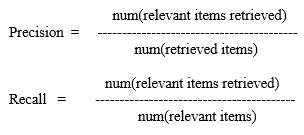

# Precision at 3 (P3)
Precision at 3 (P3): Number of relevant documents in the top 3 ranked
results, averaged over all queries. Since each query contains 3 precedents
and statutes on average, we report this score for the runs.

As we average the relevance scores for total of 50 queries, we get 3.9, so we consider the top 3 for precision and recall.

In [74]:
relevant_cases.groupby(['Query_num'])['Relevance_score'].agg('sum').describe()

count    50.00000
mean      3.90000
std       3.81859
min       1.00000
25%       2.00000
50%       3.00000
75%       4.75000
max      22.00000
Name: Relevance_score, dtype: float64

## Finding true realevant ones  in top 3

In [75]:
true_relevants

,case_no,query_no
1192,C14,1
2274,C9,1
3076,C27,2
3676,C22,2
6033,C1,3
...,...,...
140861,C38,49
142203,C76,49
142450,C92,49
143069,C27,50


In [76]:
# Checking whether our algorithm predicts same relevant case

pred_set = set(predicted_df[predicted_df.query_no==18].case_no.to_list())
pred_set

{'C115', 'C116', 'C188'}

In the above output, we can see that our code predicted the correct relevant case along with two other cases, which means our program is working correctly.

# Counting to calculate for precision and recall

In [77]:
count_relevance_found = 0

for i in range(50):
    rel_list= true_relevants[true_relevants.query_no==i].case_no.to_list()
    pred_set = set(predicted_df[predicted_df.query_no==i].case_no.to_list())

    # For each case in true relevant case, find how many of our predictions were correct
    
    for item in rel_list:
        if item in pred_set:
            count_relevance_found +=1
    

In [78]:
count_relevance_found

12

In [79]:
# num(relevant items) 

count_relevant_items = len(true_relevants)
#195
how_many_were_retrived =50 * 3

Precision = count_relevance_found/how_many_were_retrived
Recall = count_relevance_found/count_relevant_items

print(Precision)
print(Recall)

0.08
0.06153846153846154


We achieved 0.08 Precision and 0.06 Recall, which reflects that the task is challenging. Note that there is no supervision involved in any of the methods.

### We are testing another method to determine if it can provide better precision and recall

# BM25
> BM25 is a ranking function that ranks a set of documents based on the query terms appearing in each document, regardless of the inter-relationship between the query terms within a document (e.g., their relative proximity). It is not a single function, but actually a whole family of scoring functions, with slightly different components and parameters. It is used by search engines to rank matching documents according to their relevance to a given search query and is often referred to as “Okapi BM25,” since the Okapi information retrieval system was the first system implementing this function. The BM25 retrieval formula belongs to the BM family of retrieval models (BM stands for Best Match)

In [80]:
casedoc_cleaned['clean_case_detail'] = casedoc_cleaned['case_num'] +' '+ casedoc_cleaned['clean_case_detail']

In [81]:
casedoc_cleaned.head(5)

,case_num,case_detail,clean_case_detail,group_kmeans,group_dbscan
0,C1,Masud Khan v State Of Uttar Pradesh\nSupreme C...,C1 masud khan v state uttar pradesh suprem cou...,0,0
1,C10,"Prabhakaran Nair, Etc. v State Of Tamil Nadu A...",C10 prabhakaran nair etc v state tamil nadu or...,0,1
2,C100,Hiten P. Dalal v Bratindranath Banerjee\nSupre...,C100 hiten p dalal v bratindranath banerje sup...,0,1
3,C1000,Ashok Kumar and Others v State of Tamil Nadu\n...,C1000 ashok kumar other v state tamil nadu sup...,1,2
4,C1001,Ashok Dhingra v N.C.T. of Delhi\nSupreme Court...,C1001 ashok dhingra v nct delhi suprem court i...,0,0


In [82]:
corpus = casedoc_cleaned["clean_case_detail"].to_list()

In [83]:
multiple_query = query_cleaned["clean_query"].to_list()

In [84]:
tokenized_query = [each_query.split(" ") for each_query in multiple_query]

In [85]:
from rank_bm25 import BM25Okapi

tokenized_corpus = [doc.split(" ") for doc in corpus]

bm25 = BM25Okapi(tokenized_corpus)

doc_scores = bm25.get_scores(tokenized_query[0])

In [86]:
bm25.corpus_size

2914

In [87]:
top_3_cases_list=[]
for i in range(len(tokenized_query)):
    top_3_cases_list.append(bm25.get_top_n(tokenized_query[i],corpus, n=3))

In [88]:
top_3_cases_name_list=[]
for i in range(len(tokenized_query)):
    
    top_3_cases_name_list.append([top_3_cases_list[i][0].split(" ")[0],
                                  top_3_cases_list[i][1].split(" ")[0],
                                  top_3_cases_list[i][2].split(" ")[0]
                                 
                                ])

In [89]:
true_relevants[true_relevants.query_no==3].case_no.to_list()

['C1']

In [90]:
top_3_cases_name_list

[['C1651', 'C2517', 'C1240'],
 ['C2316', 'C2846', 'C2798'],
 ['C294', 'C1147', 'C103'],
 ['C2121', 'C2726', 'C1381'],
 ['C1550', 'C1821', 'C128'],
 ['C2267', 'C1550', 'C2167'],
 ['C128', 'C1396', 'C2365'],
 ['C2571', 'C1550', 'C1154'],
 ['C1550', 'C2167', 'C2109'],
 ['C1874', 'C2260', 'C892'],
 ['C1354', 'C73', 'C2017'],
 ['C575', 'C1658', 'C299'],
 ['C362', 'C2541', 'C2022'],
 ['C1550', 'C46', 'C1262'],
 ['C297', 'C1550', 'C2810'],
 ['C2340', 'C2267', 'C2866'],
 ['C73', 'C1547', 'C730'],
 ['C188', 'C115', 'C581'],
 ['C2859', 'C2340', 'C1550'],
 ['C1550', 'C1213', 'C1678'],
 ['C113', 'C1714', 'C245'],
 ['C210', 'C2373', 'C2270'],
 ['C1792', 'C401', 'C1237'],
 ['C2859', 'C2151', 'C2518'],
 ['C2869', 'C2363', 'C1022'],
 ['C581', 'C48', 'C1161'],
 ['C91', 'C1824', 'C366'],
 ['C2340', 'C128', 'C2267'],
 ['C169', 'C1550', 'C2102'],
 ['C459', 'C833', 'C1154'],
 ['C1161', 'C93', 'C2339'],
 ['C1821', 'C2267', 'C1184'],
 ['C128', 'C186', 'C236'],
 ['C162', 'C1668', 'C1667'],
 ['C1821', 'C2267',

In [91]:
count_relevance_found = 0

for i in range(50):
    rel_list= true_relevants[true_relevants.query_no==i+1].case_no.to_list()
    pred_set = set(top_3_cases_name_list[i])

    # For each case in true relevant case, find how many of our predictions were correct
    
    for item in rel_list:
        if item in pred_set:
            count_relevance_found +=1

In [92]:
count_relevance_found

14

In [93]:
# num(relevant items) 

count_relevant_items = len(true_relevants)
#195
how_many_were_retrived =50 * 3

Precision = count_relevance_found/how_many_were_retrived
Recall = count_relevance_found/count_relevant_items

print(Precision)
print(Recall)

0.09333333333333334
0.07179487179487179


#### From the above it can be said that BM25 indeed improved the precision and recall rates.
> We do not see significant improvement in the precision and recall rates for the BM25 ranking function and the statistical significance test also proves the same. But the difference in performance of BM25 by 1% is practically significant since the BM25 ranking function has been applied to a number of ad hoc information retrieval tasks. Search engines use the BM25 ranking function to estimate the relevance of documents to a given search query. BM25 is based on a probabilistic information retrieval model that incorporates document frequency, term frequency, and document length attributes. The BM25 is arguably the most efficient and widely used method for retrieving information.

# Statistical Significance
- Find which algorithm is better or do they even differ
- Null Hypothesis, H0 : 2 algorithms dont differ in performance (delta = precison_TFIDF ~ precision_bm25)
- H1 : 2 algorithms  differes 

In [94]:
# find random 30 queries out of 50.
import random
random_query_no = random.sample(range(50), 30)

In [95]:
#true_relevants
#top_3_cases_name_list

def generate_precision_recall_sample(true_relevants,predicted_3_cases_names_list,N):
    
    # N is sample size
    random_query_no = random.sample(range(50), N)

    count_relevance_found = 0

    for i in random_query_no:
        rel_list= true_relevants[true_relevants.query_no==i+1].case_no.to_list()
        
        if type(predicted_3_cases_names_list) =='list':
            #if list dataframe
            pred_set = set(predicted_3_cases_names_list[i])
        else:
            #if pandas dataframe
            pred_set = set(predicted_df[predicted_df.query_no==i+1].case_no.to_list())

        # For each case in true relevant case, find how many of our predictions were correct

        for item in rel_list:
            if item in pred_set:
                count_relevance_found +=1
                
    
    
    # num(relevant items)
    count_relevant_items = len(true_relevants)
    #195
    how_many_were_retrived =N * 3

    Precision = count_relevance_found/how_many_were_retrived
    Recall = count_relevance_found/count_relevant_items
    return((Precision,Recall))

In [96]:
tfidf_precision_recall = []
for i in range(1000):
    each_precision_recall = generate_precision_recall_sample(true_relevants,predicted_df,30)
    tfidf_precision_recall.append(each_precision_recall)


(array([  4.,   0.,   0.,  30.,   0.,  55.,   0.,   0., 113.,   0.,   0.,
          0., 140.,   0., 194.,   0.,   0., 162.,   0.,   0.,   0., 161.,
          0.,  94.,   0.,   0.,   0.,  38.,   0.,   9.]),
 array([0.01025641, 0.01196581, 0.01367521, 0.01538462, 0.01709402,
        0.01880342, 0.02051282, 0.02222222, 0.02393162, 0.02564103,
        0.02735043, 0.02905983, 0.03076923, 0.03247863, 0.03418803,
        0.03589744, 0.03760684, 0.03931624, 0.04102564, 0.04273504,
        0.04444444, 0.04615385, 0.04786325, 0.04957265, 0.05128205,
        0.05299145, 0.05470085, 0.05641026, 0.05811966, 0.05982906,
        0.06153846]),
 <BarContainer object of 30 artists>)

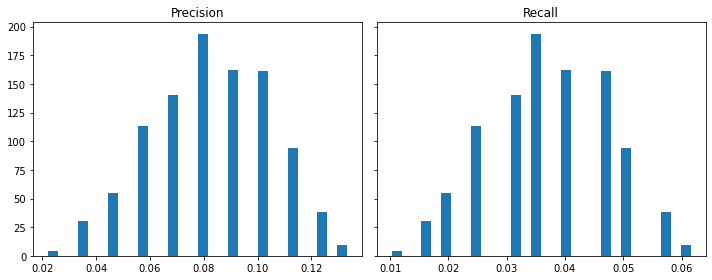

In [97]:
# Generating two (Precision and Recall)distributions for TF-IDF

precision = [precision for precision,recall in tfidf_precision_recall ] 
recall = [recall for precision,recall in tfidf_precision_recall]

n_bins=30
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True , figsize=(10, 4))

# We can set the number of bins with the *bins* keyword argument.
axs[0].set_title("Precision")
axs[0].hist(precision,bins=n_bins)
axs[1].set_title("Recall")
axs[1].hist(recall,bins=n_bins)

In [98]:
bm25_precision_recall = []
for i in range(1000):
    each_precision_recall = generate_precision_recall_sample(true_relevants,top_3_cases_name_list,30)
    bm25_precision_recall.append(each_precision_recall)

(array([  1.,   0.,   8.,   0.,   0.,  25.,   0.,   0.,  66.,   0., 110.,
          0.,   0., 149.,   0.,   0., 173.,   0.,   0., 197.,   0., 154.,
          0.,   0.,  84.,   0.,   0.,  24.,   0.,   9.]),
 array([0.00512821, 0.00700855, 0.00888889, 0.01076923, 0.01264957,
        0.01452991, 0.01641026, 0.0182906 , 0.02017094, 0.02205128,
        0.02393162, 0.02581197, 0.02769231, 0.02957265, 0.03145299,
        0.03333333, 0.03521368, 0.03709402, 0.03897436, 0.0408547 ,
        0.04273504, 0.04461538, 0.04649573, 0.04837607, 0.05025641,
        0.05213675, 0.05401709, 0.05589744, 0.05777778, 0.05965812,
        0.06153846]),
 <BarContainer object of 30 artists>)

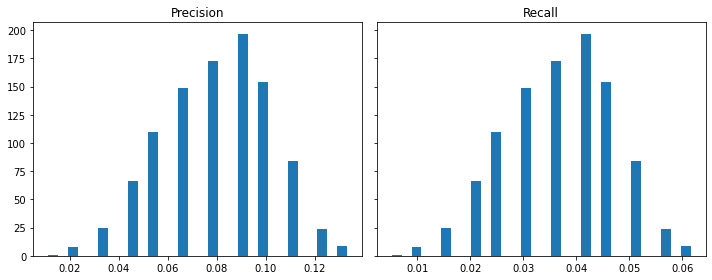

In [99]:
# Generating two (Precision and Recall)distributions for BM25

precision = [precision for precision,recall in bm25_precision_recall ] 
recall = [recall for precision,recall in bm25_precision_recall]

n_bins=30
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True , figsize=(10, 4))

# We can set the number of bins with the *bins* keyword argument.
axs[0].set_title("Precision")
axs[0].hist(precision,bins=n_bins)
axs[1].set_title("Recall")
axs[1].hist(recall,bins=n_bins)

### The data is not normally distributed despite the visual appearance of a normal distribution in the above plot. The Shapiro-Wilk test is performed to prove that the data is not normally distributed.

In [100]:
list_tfidf_bm25 =[]
for tfidf,bm25 in zip(tfidf_precision_recall,bm25_precision_recall):
    list_tfidf_bm25.append([tfidf[0],tfidf[1],bm25[0],bm25[1]])

In [101]:
df_tfidf_bm25 = pd.DataFrame (list_tfidf_bm25, columns = ['tfidf_precision', 'tfidf_recall','bm25_precision', 'bm25_recall'])
print (df_tfidf_bm25)

     tfidf_precision  tfidf_recall  bm25_precision  bm25_recall
0           0.088889      0.041026        0.055556     0.025641
1           0.111111      0.051282        0.100000     0.046154
2           0.122222      0.056410        0.088889     0.041026
3           0.088889      0.041026        0.066667     0.030769
4           0.088889      0.041026        0.055556     0.025641
..               ...           ...             ...          ...
995         0.055556      0.025641        0.055556     0.025641
996         0.088889      0.041026        0.055556     0.025641
997         0.077778      0.035897        0.066667     0.030769
998         0.044444      0.020513        0.066667     0.030769
999         0.066667      0.030769        0.077778     0.035897

[1000 rows x 4 columns]


# Normality Check - Shapiro-Wilk Test
> The Shapiro-Wilk test is a statistical test used to check if a continuous variable follows a normal distribution. The null hypothesis (H0) states that the variable is normally distributed, and the alternative hypothesis (H1) states that the variable is NOT normally distributed. So after running this test:
- If p ≤ 0.05: then the null hypothesis can be rejected.
- If p > 0.05: then the null hypothesis cannot be rejected.

In [102]:
from scipy import stats

In [103]:
stats.shapiro(df_tfidf_bm25['tfidf_precision'])

ShapiroResult(statistic=0.9731035828590393, pvalue=1.1842279544135859e-12)

In [104]:
stats.shapiro(df_tfidf_bm25['bm25_precision'])

ShapiroResult(statistic=0.9732929468154907, pvalue=1.3417838888585276e-12)

#### The p-value is less than 0.05 and hence we reject the null hypothesis and conclude that the data is not normally distributed.

# Wilcoxon Test
> The Wilcoxon-Test tests whether there is a difference between two samples. For Wilcoxon-Test, the data do not have to be normally distributed. 
- H0 : No difference in the performance of two algorithms (TF-IDF and BM25)
- H1 : Two algorithms differ and the algorithm BM25 performed better than  TF-IDF.
- If p ≤ 0.05: then the null hypothesis can be rejected.
- If p > 0.05: then the null hypothesis cannot be rejected.

In [111]:
dif_precision = df_tfidf_bm25['tfidf_precision']- df_tfidf_bm25['bm25_precision']

In [112]:
res = stats.wilcoxon(dif_precision, alternative='greater')
res.statistic, res.pvalue

(192004.0, 0.1423671330805102)

#### As the p-value is greater than 5%, we cannot reject the null hypothesis, and the results also indicate that there is no performance difference between the algorithms

In [113]:
dif_recall = df_tfidf_bm25['tfidf_recall']- df_tfidf_bm25['bm25_recall']

In [114]:
res = stats.wilcoxon(dif_recall, alternative='greater')
res.statistic, res.pvalue

(192587.5, 0.12511768250100297)

#### As the p-value is greater than 5%, we cannot reject the null hypothesis, and the results also indicate that there is no performance difference between the algorithms